# Faster RCNN

## Identical Initial Setting as FAST RCNN

In [1]:
import os 
import glob
import pandas as pd
from collections import Counter 
import cv2
import numpy as np
import random
from sklearn.model_selection import train_test_split


import torch

import torch.nn as nn
from torch.utils.data import Dataset,DataLoader

from torchsummary import summary


from torchvision import models
from torchvision import transforms as T

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as patches

from dataload import xml_to_csv,PetData,Sub_region_train,Sub_region

from tqdm import tqdm

from metrics import iou

import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage

In [5]:
##Loading data
#root_path="D:/Dataset/Pet_Data/"
root_path="D:/Dataset/Oxford"

img_path=os.path.join(root_path,"images")
annotation_path=os.path.join(root_path,"annotations/xmls")           
annots = glob.glob(annotation_path+"/*.xml")
seed=0
df=xml_to_csv(annots,img_path)
df.head()

## Make Balanced Dataset (To save time, but don't do this in real research!!)
g = df.groupby('target')
balanced_df = pd.DataFrame(g.apply(lambda x: x.sample(g.size().min(),random_state=seed).reset_index(drop=True),))  
## 
train, valid = train_test_split(balanced_df, test_size=0.3,random_state=seed)  

BATCH_SIZE = 1




In [6]:
from dataload import PetData_FASTERRCNN

In [8]:
train_ds = PetData_FASTERRCNN(train, train=True)
valid_ds= PetData_FASTERRCNN(valid, train=False)

BATCH_SIZE=2
def collate_fn(batch):
    return zip(*batch)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE
                                       , collate_fn=collate_fn,shuffle=False)
valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=BATCH_SIZE
                                       , collate_fn=collate_fn)

## Region Proposal Network

![RPN](https://i.imgur.com/QKZtjVM.png)

In [13]:
SAMPLE_DATA=train_ds[0]
IMG,GT_BOX=SAMPLE_DATA
CH,HEIGHT,WIDTH=IMG.shape
HEIGHT_RATIO=HEIGHT//16
WIDTH_RATIO=WIDTH//16

In [15]:
CENTER_X=np.arange(16,(WIDTH_RATIO+1)*16,16)
CENTER_Y=np.arange(16,(HEIGHT_RATIO+1)*16,16)
CENTER_POINTS=torch.tensor([(y,x) for x in CENTER_Y for y in CENTER_X],dtype=torch.float32)  
print(CENTER_POINTS.shape)



torch.Size([2072, 2])


## ANCHOR COORDINATES DISPLAY

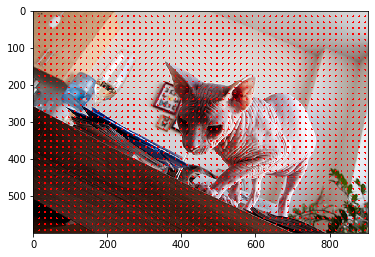

In [16]:
pil_img=T.ToPILImage()((IMG*0.5)+0.5)
img=np.asarray(pil_img)
plt.figure(figsize=(6, 6))
for ctr in CENTER_POINTS:
    cv2.circle(img, (int(ctr[0]), int(ctr[1])), radius=1, color=(255, 0, 0), thickness=2) 
plt.imshow(img)
plt.show()    

In [17]:
# We follow default of Faster_RCNN's baseline
ANCHOR_SCALES = [8,16,32] #CONTROLS THE RELATIVE SIZE OF WITHIN ANCHOR BOXES 
ANCHOR_RATIOS = [0.5,1,2] #CONTROLS THE RELATIVE ASPECT RATIO  OF ANCHOR BOXES
SAMPLE_RATIO =16 #CONTROLS THE MINIMUM SIZE OF ANCHOR BOXES


We have $(14 \times 14)$ anchor points each anchor points have  $($NUM_OF_SCALES $\times$ NUM_OF_RATIOS$)$ variations

## Creating anchor boxes

In [18]:
anchors_num=len(ANCHOR_RATIOS)*len(ANCHOR_SCALES)

anchor_boxes = torch.zeros( ((HEIGHT_RATIO * WIDTH_RATIO * len(ANCHOR_RATIOS)*len(ANCHOR_SCALES)), 4))
point_idx=0
for _,c in enumerate(CENTER_POINTS):
    ctr_y, ctr_x = c
    for i in range(len(ANCHOR_RATIOS)):
        for j in range(len(ANCHOR_SCALES)):
            h = SAMPLE_RATIO * ANCHOR_SCALES[j] * np.sqrt(ANCHOR_RATIOS[i])
            w = SAMPLE_RATIO * ANCHOR_SCALES[j] * np.sqrt(1./ ANCHOR_RATIOS[i])
            anchor_boxes[point_idx, 0] = ctr_x - w / 2.
            anchor_boxes[point_idx, 1] = ctr_y - h / 2.
            anchor_boxes[point_idx, 2] = ctr_x + w / 2.
            anchor_boxes[point_idx, 3] = ctr_y + h / 2

            point_idx+=1
           # print(point_idx)

print(anchor_boxes.shape)

torch.Size([18648, 4])


In [19]:
for idx,i in enumerate(anchor_boxes): 
    xc=int((i[0]+i[2])/2)
    yc=int((i[1]+i[3])/2)
    if xc >(WIDTH/2) and yc >(HEIGHT/2):
        center_index=idx
        print(center_index)
        break

14274


## ANCHOR BOXES DISPLAY

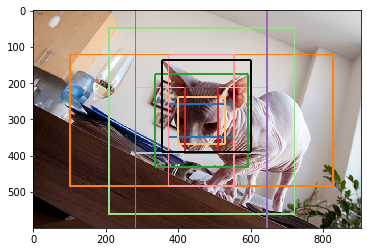

In [20]:
import seaborn as sns
palette = sns.color_palette("tab20")
pil_img=T.ToPILImage()((IMG*0.5)+0.5)
img=np.asarray(pil_img)

for idx,i in enumerate(range(center_index, center_index+anchors_num)): 
    x0 = int(anchor_boxes[i][0])
    y0 = int(anchor_boxes[i][1])
    x1 = int(anchor_boxes[i][2])
    y1 = int(anchor_boxes[i][3])
    cv2.rectangle(img, (x0, y0), (x1, y1), np.asarray(palette[idx])*255, thickness=3) 
    
for idx,i in enumerate(GT_BOX): 
    x0 = int(i[0])
    y0 = int(i[1])
    x1 = int(i[2])
    y1 = int(i[3])
    cv2.rectangle(img, (x0, y0), (x1, y1), color=(0,0,0), thickness=3)     

    
plt.imshow(img)
plt.show()  

## REMOVING ANCHOR OUT OF BOXES

Before Removal: torch.Size([18648, 4])
After Removal:torch.Size([5067, 4])


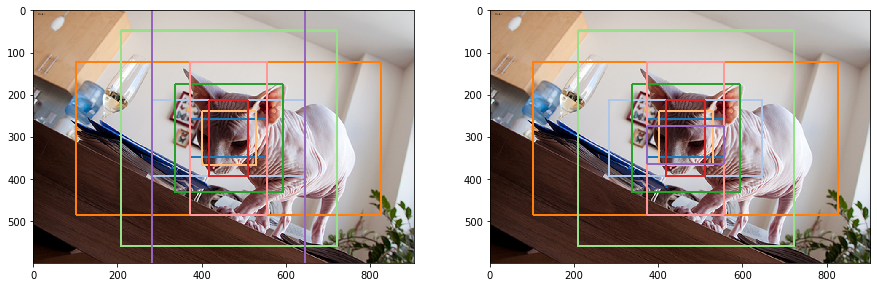

In [22]:
import seaborn as sns

img=np.asarray(T.ToPILImage()((IMG*0.5)+0.5))
##plt.figure(figsize=(20,20))
fig,ax=plt.subplots(1,2,figsize=(15,15))
for idx,i in enumerate(range(center_index, center_index+anchors_num)): 
    x0 = int(anchor_boxes[i][0])
    y0 = int(anchor_boxes[i][1])
    x1 = int(anchor_boxes[i][2])
    y1 = int(anchor_boxes[i][3])
    cv2.rectangle(img, ( x0,y0), ( x1,y1), np.asarray(palette[idx])*255, thickness=3) 
ax[0].imshow(img)

index_inside = np.where(
        (anchor_boxes[:, 0] >= 0) &
        (anchor_boxes[:, 1] >= 0) &
        (anchor_boxes[:, 2] <= WIDTH) &
        (anchor_boxes[:, 3] <= HEIGHT)
    )[0]
valid_anchor_boxes = anchor_boxes[index_inside]

print(f'Before Removal: {anchor_boxes.shape}')
print(f'After Removal:{valid_anchor_boxes.shape}')

img=np.asarray(T.ToPILImage()((IMG*0.5)+0.5))

for idx,i in enumerate(index_inside[(np.where((index_inside >=center_index) & (index_inside <=center_index+anchors_num))[0])]): 
    x0 = int(anchor_boxes[i][0])
    y0 = int(anchor_boxes[i][1])
    x1 = int(anchor_boxes[i][2])
    y1 = int(anchor_boxes[i][3])
    cv2.rectangle(img, ( x0,y0), ( x1,y1), np.asarray(palette[idx])*255, thickness=3) 
ax[1].imshow(img)
plt.show()  




## IOU cal of ANCHOR BOXES

In [23]:
ious=torch.zeros((len(valid_anchor_boxes),len(GT_BOX)))  #Each iou contains iou with each gt bounding box of the image, this case only one gt bbox per image
for box_idx,box in enumerate(valid_anchor_boxes):
    for gt_box_idx,gt_box in enumerate(GT_BOX):
        iou_area=iou.torch_getIOU(box,gt_box[0:4])
        ious[box_idx,gt_box_idx]=iou_area

##  Top  box with Each GT_BOX

In [25]:
val,indices=torch.max(ious,axis=0)

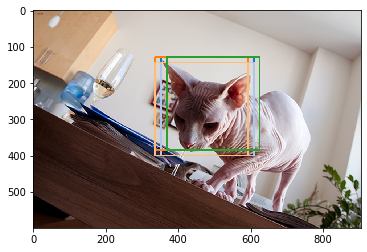

In [27]:
top_5_box=torch.topk(ious,axis=0,k=5)
plt.figure()
img=np.asarray(T.ToPILImage()((IMG*0.5)+0.5))

for idx,i in enumerate(valid_anchor_boxes[top_5_box.indices].squeeze(1)): 
    x0 = int(i[0])
    y0 = int(i[1])
    x1 = int(i[2])
    y1 = int(i[3])
    cv2.rectangle(img, (x0, y0), (x1, y1), np.asarray(palette[idx])*255, thickness=3) 
plt.imshow(img)
plt.show()  


## Make Labels for anchor box 1:object, 0:background -1:None

![img](https://i.imgur.com/C4fpjBg.png)
![img](https://i.imgur.com/1eGALoQ.png)


In [31]:
POS_THRESH_ANC=0.7
NEG_THRESH_ANC=0.3
labels=torch.ones(len(ious))*-1
labels[indices]=1
maxious=torch.max(ious,axis=1).values
labels[torch.where(maxious>=POS_THRESH_ANC)]=1
labels[torch.where(maxious<NEG_THRESH_ANC)]=0

## MINI_BATCH
here is problem, in most of the OD dataset, there are multiple objects inside a single image, bur we have only single object per dataset, we oversample positive samples little bit 

In [34]:
num_sample=64
pos_samples=int(num_sample*0.25)
neg_samples=num_sample-pos_samples
pos_index=torch.where(labels==1)[0]
neg_index=torch.where(labels==0)[0]
pos_anc=torch.cat([valid_anchor_boxes[torch.stack(random.choices(pos_index,k=pos_samples))],torch.ones(pos_samples,1)],dim=1)
neg_anc=torch.cat([valid_anchor_boxes[torch.stack(random.choices(neg_index,k=neg_samples))],torch.zeros(neg_samples,1)],dim=1)
mini_batch=torch.cat([pos_anc,neg_anc])

In [40]:
mini_batch.shape

torch.Size([64, 5])

In [41]:
mini_batch

tensor([[384.0000, 144.0000, 640.0000, 400.0000,   1.0000],
        [320.0000, 128.0000, 576.0000, 384.0000,   1.0000],
        [384.0000, 128.0000, 640.0000, 384.0000,   1.0000],
        [384.0000, 128.0000, 640.0000, 384.0000,   1.0000],
        [352.0000, 144.0000, 608.0000, 400.0000,   1.0000],
        [368.0000, 112.0000, 624.0000, 368.0000,   1.0000],
        [384.0000, 144.0000, 640.0000, 400.0000,   1.0000],
        [320.0000, 144.0000, 576.0000, 400.0000,   1.0000],
        [384.0000, 128.0000, 640.0000, 384.0000,   1.0000],
        [384.0000, 128.0000, 640.0000, 384.0000,   1.0000],
        [336.0000, 160.0000, 592.0000, 416.0000,   1.0000],
        [336.0000, 160.0000, 592.0000, 416.0000,   1.0000],
        [336.0000, 160.0000, 592.0000, 416.0000,   1.0000],
        [336.0000, 144.0000, 592.0000, 400.0000,   1.0000],
        [368.0000, 144.0000, 624.0000, 400.0000,   1.0000],
        [384.0000, 144.0000, 640.0000, 400.0000,   1.0000],
        [101.4903, 450.7452, 282.5097, 5

In [36]:
valid_anchor_boxes[torch.stack(random.choices(pos_index,k=pos_samples))].shape

torch.Size([16, 4])

In [124]:
#Input is CONV Feature MAP
#model=models.resnet18(pretrained=True).features[0:-1]
nn.Sequential([nn.functional.interpolate()])
model_ft_extractor=models.vgg16(pretrained=True).features[0:-1]
model_ft_extractor.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [126]:
model_ft_extractor(IMG.unsqueeze(0)).shape

torch.Size([1, 512, 37, 56])

In [10]:
model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)


In [11]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequent